### ***A quick augmentation to squeeze out the last bit of fine-tuning in the last stretch!***

We have already seen the cutmix augmentation where 4 images and associated bounding boxes are joined together in a single image while training. 

I have experimented and found encouraging better results while using the stitch-boxes augmentation. In this we'll just pick up image patches within bounding boxes from various images and paste it over a base image.

Let me know if anyone had already done this somewhere else. Was too lazy to search :p

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df

image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]

In [3]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [4]:
image_ids = train_df['image_id'].unique()

valid_ids = image_ids[-600:]
train_ids = image_ids[:-600]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

valid_df.shape, train_df.shape

((22688, 8), (125105, 8))

Used the pytorch dataset here but it's exactly the same while doing in Keras too!

In [5]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, test=False, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.test = test
        
    def fetch(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes
    
    # the stitch boxes aug
    
    def stitch_boxes(self, index, imsize=1024):
        
        # Increase this to pick less number of boxes from each image and vice versa.
        BOX_NUM_SELECTOR = 5
        
        all_boxes = []
        
        image, boxes = self.fetch(index)
        for box in boxes:
            all_boxes.append([int(x) for x in box])
        
        indexes = [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]
        
        for i, idx in enumerate(indexes):
            _im, _boxes = self.fetch(idx)
            _bi = [int(x) for x in random.sample(list(range(len(_boxes))), len(_boxes)//BOX_NUM_SELECTOR)]
            
            _b = _boxes[_bi]
            for box in _b:
                box = [int(x) for x in box]
                all_boxes.append(box)
                image[box[1]:box[3], box[0]:box[2]] = _im[box[1]:box[3], box[0]:box[2]]
        
        return image, np.array(all_boxes)
        
    
    # the cutmix aug
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]
    
        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
    
        for i, index in enumerate(indexes):
            image, boxes = self.fetch(index)
            
            
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
    
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh
    
            result_boxes.append(boxes)
    
        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

    def __getitem__(self, index: int):
        
        # randomizing augentations
        dice = random.random()
        if self.test == True or dice < 0.25:
            image, boxes = self.fetch(index)
        elif dice < 0.75:
            image, boxes = self.stitch_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
        
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        image_id = 0
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Alright, let's see the image.

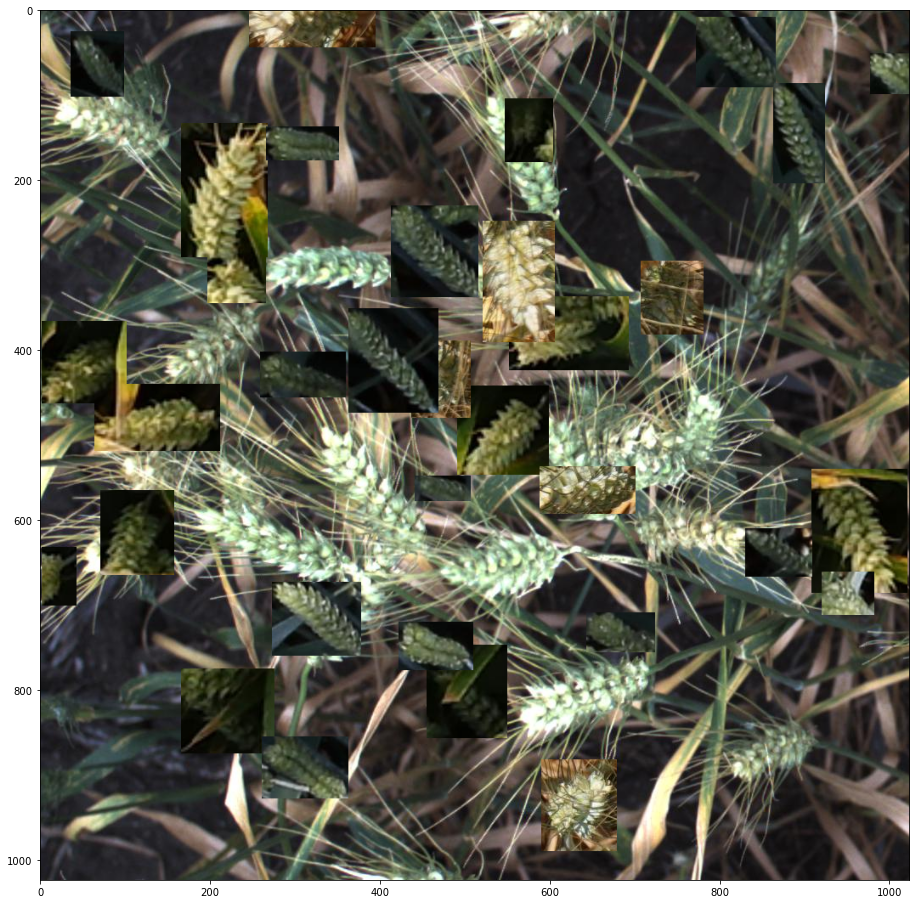

In [7]:
traindata = WheatDataset(train_df, DIR_TRAIN, get_train_transform())

im, boxes = traindata.stitch_boxes(55)
plt.figure(figsize=(16,16))
plt.imshow(im)

Now let's visualize with boxes.

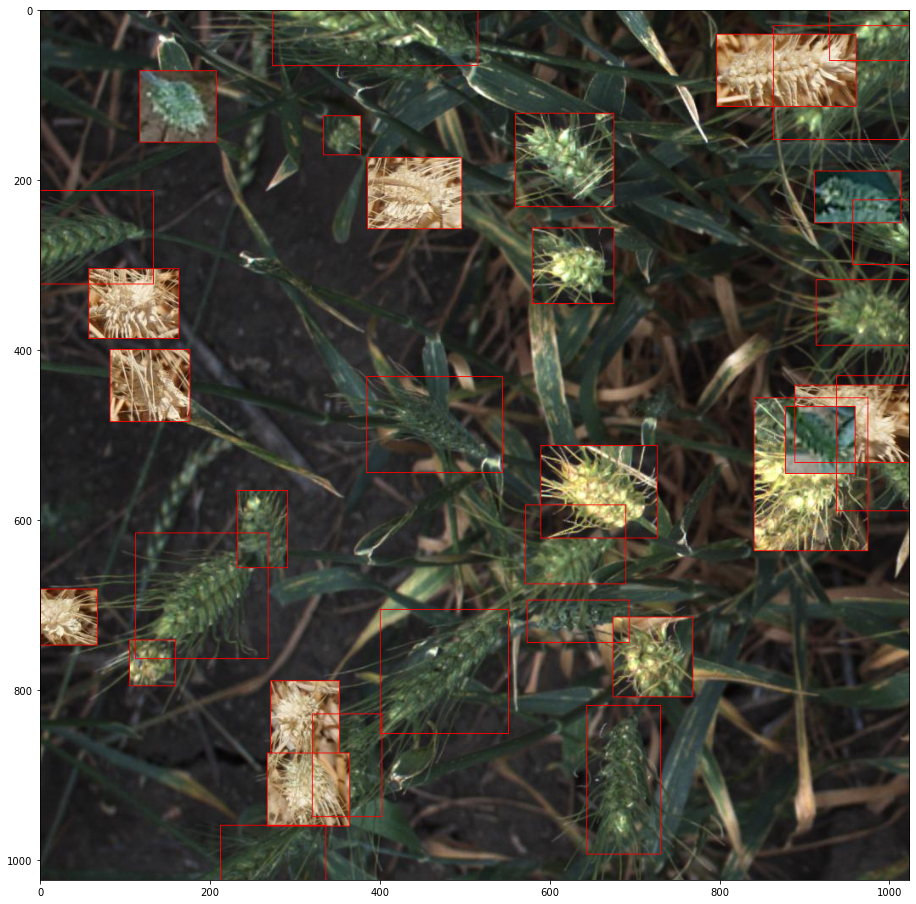

In [8]:
im, boxes = traindata.stitch_boxes(111)

for box in boxes:
    cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (255,0,0), 1)

plt.figure(figsize=(16,16))
plt.imshow(im)

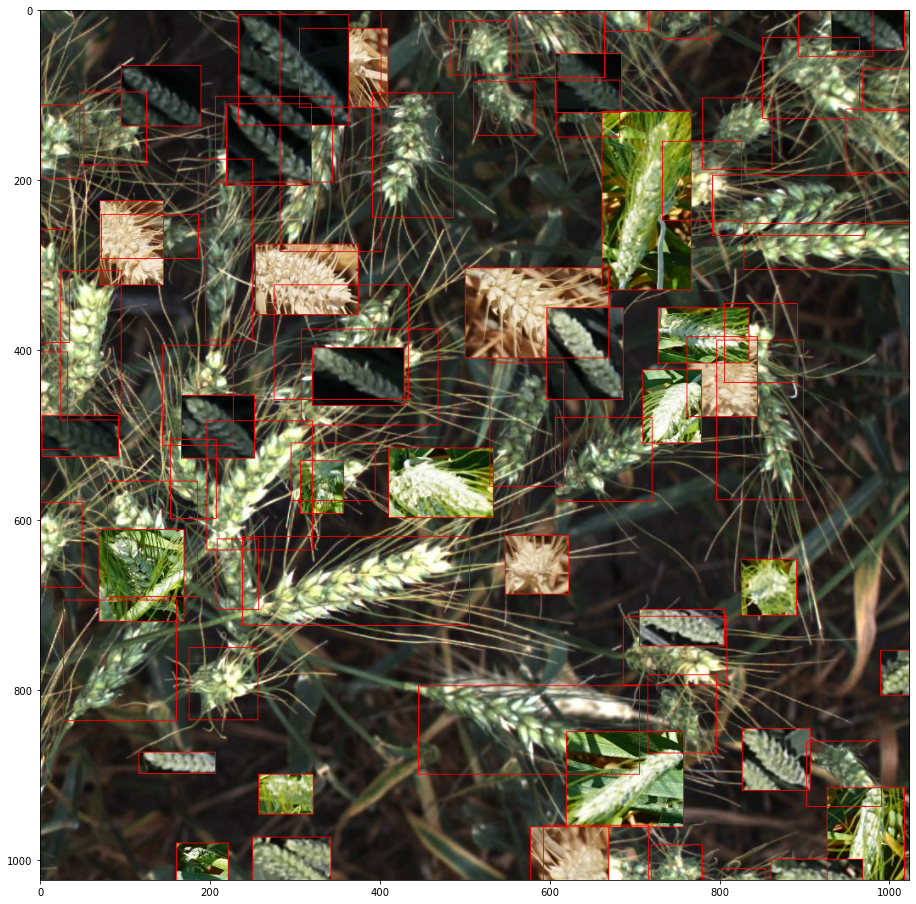

In [9]:
# This may be a simple image/ image with cutmix/ image with stitch boxes
im, target, _ = traindata[99]

for box in target['boxes']:
    cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (255,0,0), 1)

plt.figure(figsize=(16,16))
plt.imshow(im)

That's it! Use your own model and load the data from the dataset. Happy last minute training and fine-tuning!